In [1]:
%%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
# cd /content && rm -rf /content/rome
# git clone https://github.com/kmeng01/rome rome > install.log 2>&1

In [2]:
# !git clone https://github.com/kmeng01/rome

In [3]:
IS_COLAB = False
try:
    import google.colab, torch, os
    IS_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [4]:
# import os
# os.chdir('rome')
# !pip install -r /content/drive/MyDrive/rome/scripts/colab_reqs/rome.txt -q
# !pip install --upgrade google-cloud-storage -q

# Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [5]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [6]:
import os, re, json
import torch, numpy
from transformers import AutoModelForCausalLM, AutoTokenizer
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import ModelAndTokenizer, layername, guess_subject, plot_trace_heatmap
from experiments.causal_trace import make_inputs, decode_tokens, find_token_range
from experiments.causal_trace import predict_token, predict_from_input
from dsets import KnownsDataset

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [9]:
torch.set_grad_enabled(False)

model_name = r"EleutherAI/gpt-j-6B"

# Note that if you trace other models, you should set noise_level appropriately.
# (We use 0.03 for gpt-neox-20b and 0.025 for gpt-j-6b)
#model_name = r"EleutherAI/gpt-neox-20b"
#model_name = r"EleutherAI/gpt-j-6B"

torch_dtype = torch.float16 if '20b' in model_name else None

mt = ModelAndTokenizer(model_name, low_cpu_mem_usage=IS_COLAB, torch_dtype=torch_dtype)
predict_token(mt, ['Megan Rapinoe plays the sport of',
                   'The Space Needle is in the city of'
                  ], return_p=True)

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/930 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/22.5G [00:00<?, ?B/s]

([' soccer', ' Seattle'], tensor([0.6870, 0.9229], device='cuda:0'))

In [10]:
prompts = ['Megan Rapinoe plays the sport of']
device = 'cuda'
token_lists = [mt.tokenizer.encode(p) for p in prompts]
maxlen = max(len(t) for t in token_lists)
if "[PAD]" in mt.tokenizer.all_special_tokens:
    pad_id = mt.tokenizer.all_special_ids[mt.tokenizer.all_special_tokens.index("[PAD]")]
else:
    pad_id = 0
input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
inp = dict(
    input_ids=torch.tensor(input_ids).to(device),
    #    position_ids=torch.tensor(position_ids).to(device),
    attention_mask=torch.tensor(attention_mask).to(device),
)

## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [11]:
def trace_with_patch(
    model,            # The model
    inp,              # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,        # Answer probabilities to collect
    tokens_to_mix,    # Range of tokens to corrupt (begin, end)
    noise=0.1,        # Level of noise to add
    trace_layers=None # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, 'embed')
    
    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] +
            list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2)
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [12]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(mt.model, inp, [], answer_t, e_range,
            noise=noise).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )

def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)



## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [13]:
def plot_hidden_flow(
    mt, prompt, subject=None, include_plots=True, samples=10, noise=0.1, window=10, 
    kind=None, modelname=None, savepdf=None
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    if include_plots:
        plot_trace_heatmap(result, savepdf, modelname=modelname)
    return result
    
def plot_flows(mt, prompt, subject=None, plot_num=0, noise=0.1, modelname=None, 
               plots=[None, "mlp", "attn"], include_plots=True, savepdf=None, plotsubset=None, results_dict={}):
    i = plot_num
    for kind in plots:
        if kind is None:
            j = "fully_restored"
        else:
            j = kind
        if savepdf:
            filename = j + "_" + savepdf
            filepath = plotsubset + filename
            savepdf = savepdf
        results_dict[savepdf] = {}
        result = plot_hidden_flow(mt, prompt, subject, include_plots, modelname=modelname,
                                  savepdf=savepdf, noise=noise, kind=kind)
        results_dict[savepdf][j] = {}
        results_dict[savepdf][j] = result

    return results_dict

The following prompt can be changed to any factual statement to trace.

In [14]:
prompt = """Q: Take the last letters of the words in "Elon Musk" and concatenate them.
A: The last letter of "Elon" is "n". The last letter of "Musk" is "k". Concatenating them is "nk". The answer is nk.
Q: Take the last letters of the words in "Larry Page" and concatenate them.
A: The last letter of "Larry" is "y". The last letter of "Page" is "e". Concatenating them is "ye". The answer is ye.
Q: Take the last letters of the words in "Sergey Brin" and concatenate them.
A: The last letter of "Sergey" is "y". The last letter of "Brin" is "n". Concatenating them is "yn". The answer is
yn.
Q: Take the last letters of the words in "Bill Gates" and concatenate them.
A: The last letter of "Bill" is "l". The last letter of "Gates" is "s". Concatenating them is "ls". The answer is"""

prompt = """Shree Pundalik, created in the country of his birth,"""
prompt = """This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was"""
# prompt = "The famous tower people go visit in France is called the"
# prompt = "The tower named after the engineer Gustave Eiffel is called the"
# prompt = "The famous tower located located in Paris is called the"
# prompt = "The Eiffel Tower is located in"
# prompt = "The famous tower that was built to celebrate the 100th year anniversary of the French Revolution is located in the city of"

subject = """The last letter of "Bill" is "l". The last letter of "Gates" is "s". Concatenating them is "ls"."""



'This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was India.\n\nThe film was made by'

In [83]:
import numpy as np
# predict_token(mt, prompts)
device = 'cuda'
input_ids = mt.tokenizer(
        prompts[0], add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
generated_outputs = mt.model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=1+len(input_ids[0]),
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        top_k=5,
        num_beams=5,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=mt.tokenizer.eos_token_id,
        temperature=0.05
    )
# mt.tokenizer.decode(gen_outputs.sequences[0])
generated_text = mt.tokenizer.decode(generated_outputs.sequences[0])

print(prompts[0])

# only use id's that were generated
# gen_sequences has shape [3, 15]
gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]
# now we need to collect the probability of the generated token
# we need to add a dummy dim in the end to make gather work
gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
# print(gen_probs)
for j, sequence in enumerate(generated_outputs.sequences):
    generated_seq = sequence[len(sequence) - len(gen_probs[j]):len(sequence)]
    token_list = []
    for token in generated_seq:
        token_list.append(mt.tokenizer.decode(token))
    generated_text = mt.tokenizer.decode(generated_seq)
    first_token = mt.tokenizer.decode(generated_seq[0]).replace(' ', '')

token_probs = []
for token, prob in zip(generated_seq, gen_probs[0]):
    text = mt.tokenizer.decode(token)
    prob = str(np.array(prob.cpu()))
    token_probs.append((text, prob))
print(token_probs) # 0.9249657
generated_outputs.socres._topk(2)[k]

Question: Are more people today related to Genghis Khan than Julius Caesar?
Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
Answer (True or False): True
Question: Are chinchillas cold-blooded?
Facts: Chinchillas are rodents, which are mammals. All mammals are warm-blooded.
Answer:
[(' False', '0.8642137')]


/opt/conda/envs/rome/lib/python3.9/site-packages/transformers/generation_utils.py:2259: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


AttributeError: 'BeamSampleDecoderOnlyOutput' object has no attribute 'socres'

In [119]:
# # get the log probabilities of the top-k tokens
# log_probs = torch.log_softmax(generated_outputs.scores[0], dim=-1)
# topk_log_probs, topk_indices = torch.topk(log_probs, k=5, dim=-1)
# # print
# for i, (token, prob) in enumerate(zip(topk_indices, topk_log_probs)):
#     print(i, mt.tokenizer.decode(token), prob)

generated_outputs.scores[0].topk(3).values.tolist()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [108]:
mt.tokenizer(
        "True", add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)

tensor([[17821]], device='cuda:0')

In [109]:
generated_outputs.sequences[0].scores

tensor([24361,    25,  4231,   517,   661,  1909,  3519,   284,  5215,   456,
          271, 11356,   621, 32834, 24088,    30,   198,   220,   220,   220,
        26972,    25, 32834, 24088,   550,  1115,  1751,    13,  5215,   456,
          271, 11356,   550, 27913,  1751,    13, 12495,  8513,  1023,   423,
         5295,   326,   503,   286,   790,   939,  1450,  1909,   468,  7446,
          326,   460,   307, 23246,   284,  5215,   456,   271, 11356,    13,
          220,   198,   220,   220,   220, 23998,   357, 17821,   393, 10352,
         2599,  6407,   198, 24361,    25,  4231,   517,   661,  1909,  3519,
          284,  5215,   456,   271, 11356,   621, 32834, 24088,    30,   198,
           37,  8656,    25, 32834, 24088,   550,  1115,  1751,    13,  5215,
          456,   271, 11356,   550, 27913,  1751,    13, 12495,  8513,  1023,
          423,  5295,   326,   503,   286,   790,   939,  1450,  1909,   468,
         7446,   326,   460,   307, 23246,   284,  5215,   456, 

In [62]:
prompts = ["""Shree Pundalik, created in the country of his birth,""",
           """This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was""",
           "The famous tower people go visit in France is called the",
           "The tower named after the engineer Gustave Eiffel is called the",
           "The famous tower located located in Paris is called the",
           "The Eiffel Tower is located in",
           "The famous tower that was built to celebrate the 100th year anniversary of the French Revolution is located in the city of",
           "The mother tongue of Danielle Darrieux is",
           """The mother tongue of the lead actress from the film 'The Earrings of Madame de' is""",
           "Iron Man is affiliated with the",
           "The Marvel hero in the iron suit is affiliated with the",
           "In Singapore, the language spoken is",
           "The country where Lee Hsien Loong is the prime minister mainly speaks in",
           ]
subjects = ["Shree Pundalik",
            "silent film produced by Dadasaheb Torne was released in 18 May 1912",
            "famous tower people go visit in France",
            "tower named after the engineer Gustave Eiffel",
            "Eiffel Tower",
            "famous tower that was built to celebrate the 100th year anniversary of the French Revolution",
            "Danielle Darrieux",
            "lead actress from the film 'The Earrings of Madame de'",
            "Iron Man",
            "Marvel hero in the iron suit",
            "Singapore",
            "country where Lee Hsien Loong is the prime minister",
            ]

prompts = ["In the country of Singapore, the main language that is spoken is"]
subjects = ["Singapore"]


prompts = ["""Question: Are more people today related to Genghis Khan than Julius Caesar?
Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
Answer (True or False): True
Question: Are chinchillas cold-blooded?
Facts: Chinchillas are rodents, which are mammals. All mammals are warm-blooded.
Answer:"""]

subjects = ["Chinchillas are rodents, which are mammals. All mammals are warm-blooded."]

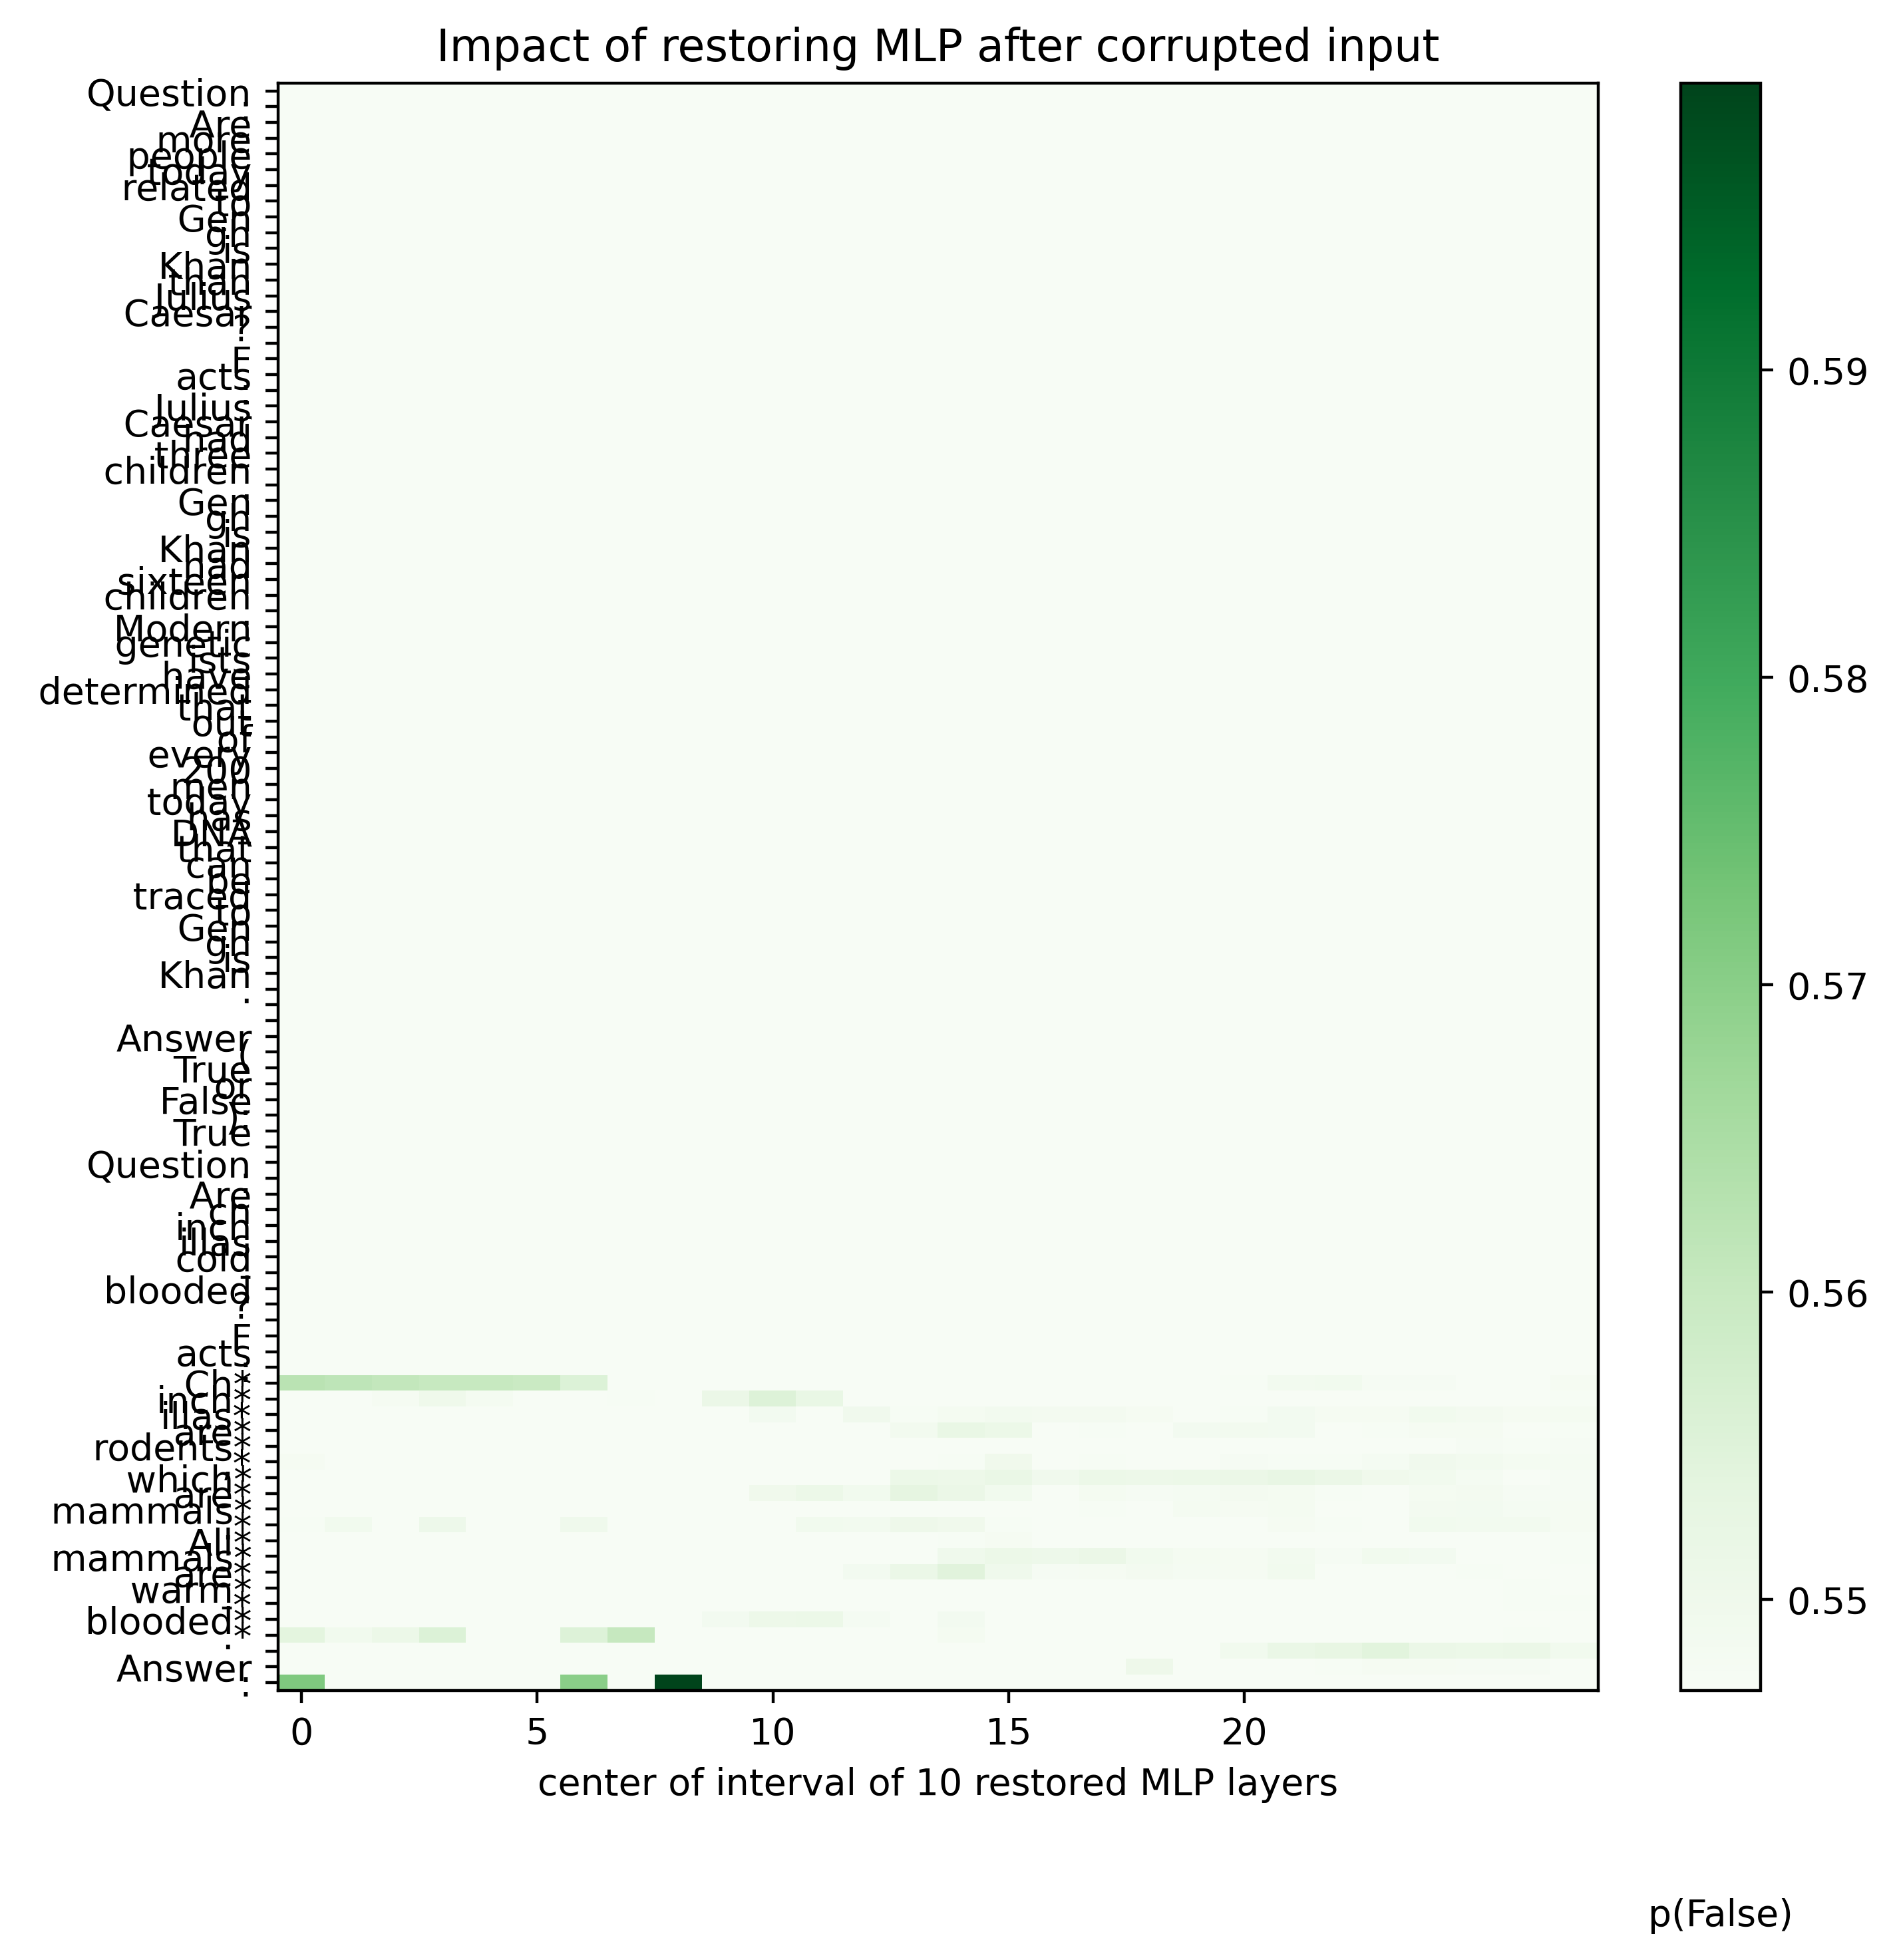

In [18]:
for prompt, subject in zip(prompts, subjects):
    plot_flows(mt, prompt, plots=['mlp'], subject=subject)

In [31]:
txt = """Question: Are more people today related to Genghis Khan than Julius Caesar?
Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
Answer (True or False): True\nQuestion: this is a test\nFacts: andso\nAnswer:"""

input = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
tok_list = []
for inp in input[0]:
    tok_list.append(mt.tokenizer.decode(inp))
print(tok_list[68:])

['Question', ':', ' Are', ' ch', 'inch', 'illas', ' cold', '-', 'blooded', '?', '\n', 'F', 'acts', ':', ' Ch', 'inch', 'illas', ' are', ' rodents', ',', ' which', ' are', ' mammals', '.', ' All', ' mammals', ' are', ' warm', '-', 'blooded', '.', '\n', 'Answer', ':']


Here we trace a few more factual statements from a file of test cases.

In [49]:
knowns = KnownsDataset(DATA_DIR)

# for knowledge in knowns[0:1]:
#     plot_flows(mt, knowledge['prompt'], knowledge['subject'])

Loaded dataset with 1209 elements


Now, let's try to find out some interesting stuff using Causal Tracing. Are there some patterns we can recognize?

Let's run through the entire Known dataset and then have a look at some commonalities between the subjects that have more effect in the later layers than the earlier layers.

In [37]:
knowns[0]

{'known_id': 0,
 'subject': 'Vinson Massif',
 'attribute': 'Antarctica',
 'template': '{} is located in the continent',
 'prediction': ' of Antarctica. It is the largest of the three',
 'prompt': 'Vinson Massif is located in the continent of',
 'relation_id': 'P30'}

In [38]:
import json

good_cf_filename = "/content/drive/MyDrive/rome/data/good_counterfact_gpt2.json"
with open(good_cf_filename, 'r') as f:
    good_cfs = json.loads(f.read())

bad_cf_filename = "/content/drive/MyDrive/rome/data/bad_counterfacts_gpt2.json"
with open(bad_cf_filename) as f:
    bad_cfs = json.loads(f.read())

In [39]:
float(bad_cfs['0']['token_probs'][0][1])

0.9990845

In [40]:
uncertain_count = 0
certain_count = 0
bad_uncertain_cfs = {}
bad_certain_cfs = {}
for i in list(bad_cfs.keys()):
    first_gen_token_prob = float(bad_cfs[i]['token_probs'][0][1])
    if first_gen_token_prob < 0.2:
        bad_uncertain_cfs[uncertain_count] = bad_cfs[i]
        uncertain_count += 1
    elif first_gen_token_prob > 0.999:
        bad_certain_cfs[certain_count] = bad_cfs[i]
        certain_count += 1

print(uncertain_count)
print(certain_count)

486
9883


In [41]:
uncertain_count = 0
certain_count = 0
good_uncertain_cfs = {}
good_certain_cfs = {}
for i in list(good_cfs.keys()):
    first_gen_token_prob = float(good_cfs[i]['token_probs'][0][1])
    if first_gen_token_prob < 0.2:
        good_uncertain_cfs[uncertain_count] = good_cfs[i]
        uncertain_count += 1
    elif first_gen_token_prob > 0.999:
        good_certain_cfs[certain_count] = good_cfs[i]
        certain_count += 1

print(uncertain_count)
print(certain_count)

77
2677


In [19]:
savepdf = "/content/drive/MyDrive/rome/data/image.png"
if savepdf:
    print(os.path.dirname(savepdf))

/content/drive/MyDrive/rome/data


In [43]:
# import shutil
# shutil.rmtree('/content/rome/data/bad_uncertains')

In [44]:
results_dict = {}

In [ ]:
from tqdm import tqdm
i = 0
plotsubset = "/content/drive/MyDrive/rome/data/bad_uncertains/"
os.makedirs(plotsubset, exist_ok=True)
# for knowledge in knowns[0:2]:
for i in tqdm(bad_uncertain_cfs):
    try:
        subject = bad_uncertain_cfs[i]['requested_rewrite']['subject']
        prompt = bad_uncertain_cfs[i]['requested_rewrite']['prompt'].replace("{}", subject)
        print(prompt)
        token_prob = str(round(float(bad_uncertain_cfs[i]['token_probs'][0][1]), 3)).replace(".", "p")
        pdf_name = token_prob + "_" + prompt.replace(' ', '_').replace(".", "_")
        pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)
        print(pdf_name)
        print(token_prob)
        results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                                include_plots=True, plots=["mlp"], 
                                savepdf=pdf_name, plotsubset=plotsubset, results_dict=results_dict)
    except:
        pass
    i += 1
    if i > 100:
        break

In [ ]:
from tqdm import tqdm
i = 0
# results_dict = {}
plotsubset = "/content/drive/MyDrive/rome/data/knowns/"
os.makedirs(plotsubset, exist_ok=True)
for known in tqdm(knowns[0:50]):
    try:
        subject = known['subject']
        prompt = known['prompt'].replace("{}", subject)
        pdf_name = prompt.replace(' ', '_').replace(".", "_")
        pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)
        print(pdf_name)
        results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                                include_plots=True, plots=["mlp"], 
                                savepdf=pdf_name, plotsubset=plotsubset, results_dict=results_dict)
    except:
        pass
    i += 1
    # if i > 400:
    #     break

In [ ]:
for i in tqdm(good_certain_cfs):
    try:
        subject = good_certain_cfs[i]['requested_rewrite']['subject']
        prompt = good_certain_cfs[i]['requested_rewrite']['prompt'].replace("{}", subject)
        token_prob = str(round(float(good_certain_cfs[i]['token_probs'][0][1]), 3)).replace(".", "p")
        pdf_name = token_prob + "_" + prompt.replace(' ', '_').replace(".", "_")
        pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)
        print(pdf_name)
        print(token_prob)
        results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                                include_plots=True, plots=["mlp"], 
                                savepdf=pdf_name, plotsubset=plotsubset, results_dict=results_dict)
    except:
        pass
    i += 1
    if i > 100:
        break

In [ ]:
import pickle

with open("/content/drive/MyDrive/rome/data/causal_tracing_results_dict.pkl", "wb") as f:
    pickle.dump(results_dict, f)

In [50]:
from google.colab import files
files.download("/content/drive/MyDrive/rome/data/causal_tracing_results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import pickle
with open("/content/drive/MyDrive/rome/data/causal_tracing_results_dict.pkl", "rb") as f:
    ct_dict = pickle.load(f)

In [22]:
keys = list(ct_dict.keys())
ct_dict[keys[0]]

{'mlp': {'scores': tensor([[0.0496, 0.0495, 0.0494, 0.0493, 0.0493, 0.0493, 0.0391, 0.0386, 0.0390,
           0.0375, 0.0355, 0.0364, 0.0354, 0.0352, 0.0353, 0.0354, 0.0354, 0.0354,
           0.0355, 0.0355, 0.0355, 0.0355, 0.0354, 0.0355, 0.0355, 0.0355, 0.0355,
           0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355,
           0.0355, 0.0355, 0.0356, 0.0356, 0.0356, 0.0356, 0.0356, 0.0356, 0.0356,
           0.0356, 0.0356, 0.0356],
          [0.0609, 0.0622, 0.0644, 0.0627, 0.0601, 0.0621, 0.0511, 0.0286, 0.0201,
           0.0165, 0.0170, 0.0164, 0.0216, 0.0258, 0.0238, 0.0237, 0.0288, 0.0293,
           0.0360, 0.0408, 0.0391, 0.0366, 0.0362, 0.0358, 0.0353, 0.0346, 0.0355,
           0.0364, 0.0360, 0.0354, 0.0351, 0.0350, 0.0350, 0.0350, 0.0352, 0.0355,
           0.0354, 0.0353, 0.0356, 0.0356, 0.0358, 0.0359, 0.0359, 0.0360, 0.0360,
           0.0359, 0.0358, 0.0359],
          [0.0368, 0.0362, 0.0360, 0.0355, 0.0352, 0.0342, 0.0394, 0.0359, 0.0352

In [37]:
good_certain_cfs[0]

{'case_id': 0,
 'pararel_idx': 2796,
 'requested_rewrite': {'prompt': 'The mother tongue of {} is',
  'relation_id': 'P103',
  'target_new': {'str': 'English', 'id': 'Q1860'},
  'target_true': {'str': 'French', 'id': 'Q150'},
  'subject': 'Danielle Darrieux'},
 'paraphrase_prompts': ['Shayna does this and Yossel goes still and dies. Danielle Darrieux, a native',
  'An album was recorded for Capitol Nashville but never released. Danielle Darrieux spoke the language'],
 'neighborhood_prompts': ['The mother tongue of Léon Blum is',
  'The native language of Montesquieu is',
  'François Bayrou, a native',
  'The native language of Raymond Barre is',
  'Michel Rocard is a native speaker of',
  'Jacques Chaban-Delmas is a native speaker of',
  'The native language of François Bayrou is',
  'Maurice Genevoix, speaker of',
  'The mother tongue of François Bayrou is',
  'Melchior de Vogüé, speaker of'],
 'attribute_prompts': ['J.\xa0R.\xa0R. Tolkien is a native speaker of',
  'The mother tongue

In [36]:
prompt = good_certain_cfs[0]['requested_rewrite']['prompt']
prompt = prompt.replace("{}", good_certain_cfs[0]['requested_rewrite']['subject'])
print(prompt)

The mother tongue of Danielle Darrieux is


In [45]:
input_tokens = [53, 7899, 5674, 361, 313, 5140, 287, 262, 15549, 286]
for j in knowns[0:50]:
    id = j['known_id']
    for i in good_certain_cfs:
        prompt = good_certain_cfs[0]['requested_rewrite']['prompt']
        prompt = prompt.replace("{}", good_certain_cfs[0]['requested_rewrite']['subject'])
        # input_tokens = mt.tokenizer.encode(prompt)
        if knowns[id]['prompt'] == prompt:
            print('yes')
            # knowns[id] = good_certain_cfs[i]['token_probs']
            break

In [ ]:
import numpy as np
from tqdm import tqdm
count = 0
good_knowns = {}
for i, known in tqdm(enumerate(knowns[0:200])):
    prompt = known['prompt']
    input_ids = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
    generated_outputs = mt.model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=40,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=mt.tokenizer.eos_token_id,
        temperature=0.05
    )
    generated_text = mt.tokenizer.decode(generated_outputs.sequences[0])

    # only use id's that were generated
    # gen_sequences has shape [3, 15]
    gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
    probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]
    # now we need to collect the probability of the generated token
    # we need to add a dummy dim in the end to make gather work
    gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
    # print(gen_probs)
    for j, sequence in enumerate(generated_outputs.sequences):
        generated_seq = sequence[len(sequence) - len(gen_probs[j]):len(sequence)]
        token_list = []
        for token in generated_seq:
            token_list.append(mt.tokenizer.decode(token))
        generated_text = mt.tokenizer.decode(generated_seq)
        first_token = mt.tokenizer.decode(generated_seq[0]).replace(' ', '')
    
    token_probs = []
    for token, prob in zip(generated_seq, gen_probs[0]):
        text = mt.tokenizer.decode(token)
        prob = str(np.array(prob.cpu()))
        token_probs.append((text, prob))

    knowns[i]["gpt2_main_completion"] = generated_text
    knowns[i]["token_probs"] = token_probs
    if first_token == knowns[i]['attribute']:
        print("Good known: ", first_token)
        good_knowns[j] = knowns[i]
        good_knowns[j]["first_token"] = first_token
        j += 1
    

In [ ]:
known

In [72]:
import pandas as pd
knowns[0]
prompts = []
correct_answer = []
probs = []
for known in knowns[0:200]:
    prompts.append(known['prompt'])
    correct_answer.append(known['attribute'])
    probs.append(known['token_probs'][0][0])
df = pd.DataFrame({"prompt": prompts, "correct_answer": correct_answer, "prob": probs})
df.head()

,prompt,correct_answer,prob
0,Vinson Massif is located in the continent of,Antarctica,Antarctica
1,Beats Music is owned by,Apple,Apple
2,Audible.com is owned by,Amazon,Amazon
3,The Big Bang Theory premieres on,CBS,CBS
4,"MacApp, a product created by",Apple,Apple


In [73]:
df.to_csv("good_knowns_with_prob.csv")

In [102]:
correct_output = "Microsoft"
for k in knowns[0:50]:
    if correct_output in k['attribute']:
        print(k['attribute'])
        print(k['prompt'])
        print(k['token_probs'][0:3])

Microsoft
Xamarin, from the
[(' developer', '0.016318861'), (' team', '0.030414667'), (' at', '0.1957023')]
Microsoft
Windows Media Player is developed by
[(' V', '0.004145599'), ('LC', '0.91789305'), (',', '0.08347914')]
Microsoft
NTFS is developed by
[(' the', '0.17151275'), (' N', '0.39584285'), ('TF', '0.9532869')]
Microsoft
Windows Media Audio, a product developed by
[(' Microsoft', '0.26757678'), (' for', '0.115875155'), (' Windows', '0.3069984')]


In [ ]:
max_location = {}

for example_i in range(len(ct_dict)):
    max_effect = 0
    global_max_effect = 0
    prompt = '_P_: ' + ''.join(ct_dict[example_i]['mlp']['input_tokens'])
    answer = ' _A_:' + ct_dict[example_i]['mlp']['answer']
    text = prompt + answer
    s_start, s_end = ct_dict[example_i]['mlp']['subject_range']
    subject = ''.join(ct_dict[example_i]['mlp']['input_tokens'][s_start:s_end])
    for token_num in range(s_start, s_end):
        for layer_num in range(0,48):
            max_effect = max(ct_dict[example_i]['mlp']['scores'][token_num][layer_num], max_effect)
            if max_effect != global_max_effect:
                global_max_effect = max_effect
                peak_token = ct_dict[example_i]['mlp']['input_tokens'][token_num]
                max_location[example_i] = {"token_num": token_num, 
                                           "peak_token": peak_token,
                                           "layer_num": layer_num,
                                           "subject": subject,
                                           "text": text}

In [ ]:
early_retrievals = []
late_retrievals = []
for i in range(len(max_location)):
    if max_location[i]['layer_num'] < 12:
        early_retrievals.append(max_location[i])
    elif max_location[i]['layer_num'] > 20:
        late_retrievals.append(max_location[i])

print("Early Retrivals: ")
for er in early_retrievals:
    print(er)
print("\n-------------------------\n")
print("Late Retrivals: ")
for lr in late_retrievals:
    print(lr)

In [ ]:
text = "The official religion of Edwin of Northumbria is"

In [ ]:
predict_token(mt, [text], return_p=True)

([' the'], tensor([0.2196], device='cuda:0'))

In [ ]:
device = "cuda"
MODEL_NAME = "gpt2-xl"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
model, tok = (
    AutoModelForCausalLM.from_pretrained(MODEL_NAME, low_cpu_mem_usage=IS_COLAB).to(device),
    AutoTokenizer.from_pretrained(MODEL_NAME)
)
tok.pad_token = tok.eos_token

In [ ]:
input_ids = tok(
    text, add_special_tokens=False, return_tensors="pt"
).input_ids.to(device)
generated_outputs = model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=40,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=tok.eos_token_id,
        temperature=0.1,
    )

print(tok.decode(generated_outputs.sequences[0]))

The official religion of Edwin of Northumbria is the Church of the Holy Trinity, which is a combination of the Roman Catholic and Eastern Orthodox churches. The church is based on the belief that the Holy


# Testing Causal Tracing on Bad CounterFact Completions

In order to check if bad outputs lead to different causality on the predicted token, let's create a sub-dataset from the CounterFact dataset. We will check a portion of the examples GPT-2 gets incorrect.

In [ ]:
with open("/content/rome/data/good_counterfact_gpt2.json") as f:
    good_counterfacts = json.load(f)

with open("/content/rome/data/bad_counterfacts_gpt2.json") as f:
    bad_counterfacts = json.load(f)

# with open("/content/rome/data/counterfact.json") as f:
#     all_counterfacts = json.load(f)

In [ ]:
list_of_good_ids = []
for id in good_counterfacts.keys():
    list_of_good_ids.append(good_counterfacts[str(id)]['case_id'])

In [ ]:
j = 0
bad_counterfacts = {}
for id in range(len(all_counterfacts)):
    if id not in list_of_good_ids:
        bad_counterfacts[j] = all_counterfacts[id]
        j += 1

print(str(len(bad_counterfacts)))
print(str(len(all_counterfacts)))

16476
21919


In [ ]:
bad_counterfacts[0]

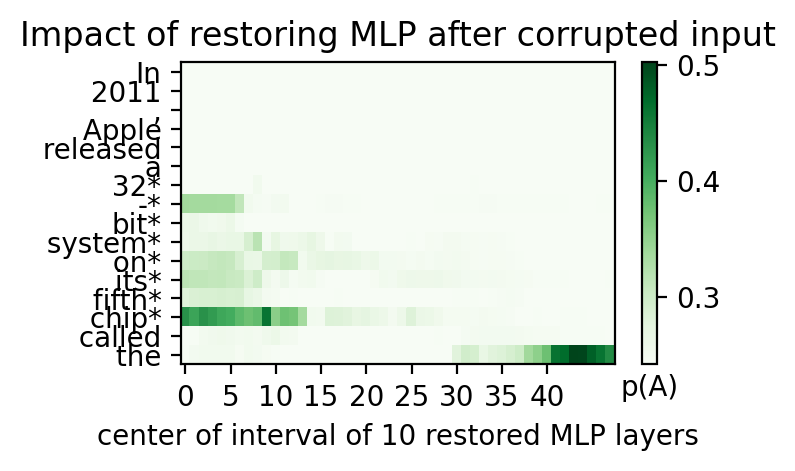

{0: {'mlp': {'scores': tensor([[0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418],
           [0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418],
           [0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418

In [ ]:
plot_flows(mt, "In 2011, Apple released a 32-bit system on its fifth chip called the", plots=['mlp'], subject="32-bit system on its fifth chip")

In [ ]:
from tqdm import tqdm

for i, cf in tqdm(enumerate(counterfact)):
    rew = cf['requested_rewrite']
    text = rew['prompt'].replace("{}", rew['subject'])

## Does more uncertainty mean more token effect spread?

In [100]:
import numpy as np
import pandas as pd

In [102]:
# results_dict[0]['mlp']['high_score']
highs = []
tops = []
i = 0
for i in results_dict:
    top_count = 0
    if list(results_dict[i].keys()) == ["mlp"]:
        high_score = round(float(results_dict[i]['mlp']['high_score']), 4)
        top = high_score * 0.6
        for token_probs in results_dict[i]['mlp']['scores']:
            for prob in token_probs:
                if prob >= top:
                    top_count += 1
    i += 1
    highs.append(high_score)
    tops.append(top_count)
    # print("High Score: ", high_score, "Top Count: ", top_count)
    # if i > 2:
    #     break

df = pd.DataFrame({"high_score": highs, "top_score_count": tops})
df.sort_values(by="high_score")

,high_score,top_score_count
35,0.0192,93
47,0.0198,432
40,0.0335,432
44,0.0341,239
49,0.0418,336
25,0.0430,336
50,0.0463,45
38,0.0482,83
48,0.0489,145
46,0.0522,80


## Load StrategyQA Dataset

In [89]:
from dsets.knowns import KnownsDataset

In [90]:
knowns = KnownsDataset(DATA_DIR)

data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json


  0%|          | 0.00/335k [00:00<?, ?B/s]

Loaded dataset with 1209 elements


In [96]:
import os
os.getcwd()

'/home/jacquesthibodeau/rome-experiments'

In [97]:
with open(os.getcwd() + '/data/strategyqa_train.json') as f:
    sqa = json.load(f)

In [98]:
sqa[0]


{'qid': 'b8677742616fef051f00',
 'term': 'Genghis Khan',
 'description': 'founder and first Great Khan of the Mongol Empire',
 'question': 'Are more people today related to Genghis Khan than Julius Caesar?',
 'answer': True,
 'facts': ['Julius Caesar had three children.',
  'Genghis Khan had sixteen children.',
  'Modern geneticists have determined that  out of every 200 men today has DNA that can be traced to Genghis Khan.'],
 'decomposition': ['How many kids did Julius Caesar have?',
  'How many kids did Genghis Khan have?',
  'Is #2 greater than #1?'],
 'evidence': [[[['Caesarion-2', 'Julia (daughter of Caesar)-1']],
   [['Alakhai Bekhi-1', 'Tolui-1'], 'no_evidence'],
   ['operation']],
  [[['Julius Caesar-75']], [['Genghis Khan-17']], ['operation']],
  [[['Gaius Julius Caesar-7']],
   [['Genghis Khan-15'], 'no_evidence'],
   ['no_evidence', 'operation']]]}

In [99]:
fact_str = "Facts: "

for f in sqa[0]['facts']:
    fact_str += f.replace("  ", " ") + " "

print("Question:", sqa[0]['question'])
print(fact_str)
print("Answer:", sqa[0]['answer'])

Question: Are more people today related to Genghis Khan than Julius Caesar?
Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
Answer: True


In [102]:
len(sqa) * 3.3 / 60

125.95

In [103]:
from tqdm import tqdm
import numpy as np
device = 'cuda'
count = 0
i = 1
for j, data in tqdm(enumerate(sqa)):
    example = """Question: Are more people today related to Genghis Khan than Julius Caesar?
    Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
    Answer (True or False): True\n"""
    fact_str = "Facts: "
    for f in data['facts']:
        fact_str += f.replace("  ", " ") + " "
    question = "Question: " + data['question']
    answer = "Answer (True or False):"
    correct_answer = str(data['answer'])
    prompt = example + question + "\n" + fact_str + "\n" + answer
    input_ids = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
    generated_outputs = mt.model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=200,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=mt.tokenizer.eos_token_id,
        temperature=0.05,
    )
    generated_text = mt.tokenizer.decode(generated_outputs.sequences[0])

    # only use id's that were generated
    # gen_sequences has shape [3, 15]
    gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
    probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]
    # now we need to collect the probability of the generated token
    # we need to add a dummy dim in the end to make gather work
    gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
    # print(gen_probs)
    for j, sequence in enumerate(generated_outputs.sequences):
        generated_seq = sequence[len(sequence) - len(gen_probs[j]):len(sequence)]
        token_list = []
        for token in generated_seq:
            token_list.append(mt.tokenizer.decode(token))
        generated_text = mt.tokenizer.decode(generated_seq)
        first_token = mt.tokenizer.decode(generated_seq[0]).replace(' ', '')
    
    token_probs = []
    for token, prob in zip(generated_seq, gen_probs[0]):
        text = mt.tokenizer.decode(token)
        prob = str(np.array(prob.cpu()))
        token_probs.append((text, prob))

    # print(correct_answer)
    # print(first_token)
    if correct_answer.lower() in first_token.lower():
        sqa[i]["first_generated_token"] = first_token
        sqa[i]["gpt2_main_completion"] = generated_text
        sqa[i]["good_gpt2_prompt"] = True
        sqa[i]["token_probs"] = token_probs
        count += 1
        i += 1
    else:
        sqa[i]["first_generated_token"] = first_token
        sqa[i]["gpt2_main_completion"] = generated_text
        sqa[i]["good_gpt2_prompt"] = False
        sqa[i]["token_probs"] = token_probs
        i += 1

print("\n\n Number of prompts that created good completions: " + str(count))

1it [00:03,  3.30s/it]

True
False


1it [00:07,  7.07s/it]


KeyboardInterrupt: 

In [ ]:
good_count = 0
bad_count = 0
good_sqa = {}
bad_sqa = {}
for i, data in tqdm(enumerate(sqa)):
    try:
        if data["good_gpt2_prompt"] == True:
            good_sqa[good_count] = data
            good_count += 1
        else:
            bad_sqa[bad_count] = data
            bad_count += 1
    except:
        pass

print("\nGood counts: " + str(good_count))
print("\nBad counts: " + str(bad_count))

In [ ]:
good_sqa_filename = "/content/drive/MyDrive/rome/data/good_sqa_gpt2.json"
with open(good_sqa_filename, "w") as f:
    json.dump(good_sqa, f)

bad_sqa_filename = "/content/drive/MyDrive/rome/data/bad_sqa_gpt2.json"
with open(bad_sqa_filename, "w") as f:
    json.dump(bad_sqa, f)


In [ ]:
from google.colab import files
files.download(good_sqa_filename)
files.download(bad_sqa_filename)